## 2012.1.1 - 2017.9.2 Baltimore Victim-Based Crime exploratory data analysis

Pulled from Kaggle: https://www.kaggle.com/datasets/sohier/crime-in-baltimore

Based upon Open Baltimore data, released to the public by the Baltimore Police Department (BPD): https://www.baltimorepolice.org/crime-stats/open-data

The dataset represents the location and characteristics of major (Part 1) crime against persons, such as homicide, shooting, robbery, aggravated assault, etc., within the City of Baltimore. These Victim-Based crimes are collectively referred to as Part 1 crimes by the BPD.

The data set runs from the first of January, 2012 to the second of September, 2017.

In [1]:
%matplotlib inline

# Dependencies
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st
import numpy as np
import seaborn as sns
import calendar

In [2]:
# read in kaggle 2012-2017 dataset
df = pd.read_csv("Resources/2012-2017_BPD_Victim_Based_Crime_Data.csv")
df.head()

,CrimeDate,CrimeTime,CrimeCode,Location,Description,Inside/Outside,Weapon,Post,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents
0,09/02/2017,23:30:00,3JK,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,913.0,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1
1,09/02/2017,23:00:00,7A,800 NEWINGTON AVE,AUTO THEFT,O,NaN,133.0,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1
2,09/02/2017,22:53:00,9S,600 RADNOR AV,SHOOTING,Outside,FIREARM,524.0,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1
3,09/02/2017,22:50:00,4C,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,934.0,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1
4,09/02/2017,22:31:00,4E,100 LIGHT ST,COMMON ASSAULT,O,HANDS,113.0,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1


## Data cleaning and preparation

Post and CrimeCode dropped. Inside/Ouside cleaned. "Time of Day" (Morning, Afternoon, Evening, Late Night) and "Day of Week" (Monday through Sunday) series added. No null values have been dropped (for example, there are ~10,000 nulls in "Inside/Outside", or 3% of the data). Sometimes they will be dropped in the individual data analyses below, depending on what is being analyzed.

At times, in the plots below, the data from 2017 will be dropped so as not to skew results. The data set runs from 1-Jan-2012 - 2-Sep-2017, so it's missing a full third of a year.


In [3]:
# data cleaning and organization

# remove series
df.drop(columns=["CrimeCode", "Post"], inplace=True)

# consolidate Inside/Outside values, merging "O" and "I" with "Outside" and "Inside"
df["Inside/Outside"] = df["Inside/Outside"].replace({"Outside": "O", "Inside": "I"})

# convert day to datetime data type
df.CrimeDate = pd.to_datetime(df.CrimeDate)

# change midnight for to_datetime
# create temp series CrimeTimeTemp for splitting data into Time of Day
df.loc[df.CrimeTime == "24:00:00", "CrimeTime"] = "00:00:00"
df["CrimeTimeTemp"] = pd.to_datetime(df.CrimeTime, format="%H:%M:%S")

# create bins and labels for morning, afternoon, evening, late night
# -1 because it kept populating "Time of Day" with NaN for any 0 hours (12am)
bins = [-1, 6, 12, 18, 24]
labels = ["Late Night", "Morning", "Afternoon", "Evening"]

# pd.cut likes ints, so dt.hour extracts the hour for comparison with bins
# remove CrimeTimeTemp from the df
df["Time of Day"] = pd.cut(df.CrimeTimeTemp.dt.hour, bins=bins, labels=labels)
df.drop(columns=["CrimeTimeTemp"], inplace=True)

# add 'Day of Week' series
df["Day of Week"] = df["CrimeDate"].dt.day_name()

In [4]:
df

,CrimeDate,CrimeTime,Location,Description,Inside/Outside,Weapon,District,Neighborhood,Longitude,Latitude,Location 1,Premise,Total Incidents,Time of Day,Day of Week
0,2017-09-02,23:30:00,4200 AUDREY AVE,ROBBERY - RESIDENCE,I,KNIFE,SOUTHERN,Brooklyn,-76.60541,39.22951,"(39.2295100000, -76.6054100000)",ROW/TOWNHO,1,Evening,Saturday
1,2017-09-02,23:00:00,800 NEWINGTON AVE,AUTO THEFT,O,NaN,CENTRAL,Reservoir Hill,-76.63217,39.31360,"(39.3136000000, -76.6321700000)",STREET,1,Evening,Saturday
2,2017-09-02,22:53:00,600 RADNOR AV,SHOOTING,O,FIREARM,NORTHERN,Winston-Govans,-76.60697,39.34768,"(39.3476800000, -76.6069700000)",Street,1,Evening,Saturday
3,2017-09-02,22:50:00,1800 RAMSAY ST,AGG. ASSAULT,I,OTHER,SOUTHERN,Carrollton Ridge,-76.64526,39.28315,"(39.2831500000, -76.6452600000)",ROW/TOWNHO,1,Evening,Saturday
4,2017-09-02,22:31:00,100 LIGHT ST,COMMON ASSAULT,O,HANDS,CENTRAL,Downtown West,-76.61365,39.28756,"(39.2875600000, -76.6136500000)",STREET,1,Evening,Saturday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276524,2012-01-01,00:00:00,1400 JOH AVE,LARCENY,I,NaN,SOUTHWESTERN,Violetville,-76.67195,39.26132,"(39.2613200000, -76.6719500000)",OTHER - IN,1,Late Night,Sunday
276525,2012-01-01,00:00:00,5500 SINCLAIR LN,LARCENY,O,NaN,NORTHEASTERN,Frankford,-76.53829,39.32493,"(39.3249300000, -76.5382900000)",OTHER - OU,1,Late Night,Sunday
276526,2012-01-01,00:00:00,400 N PATTERSON PK AV,LARCENY,O,NaN,EASTERN,CARE,-76.58497,39.29573,"(39.2957300000, -76.5849700000)",STREET,1,Late Night,Sunday
276527,2012-01-01,00:00:00,5800 LILLYAN AV,BURGLARY,I,NaN,NORTHEASTERN,Glenham-Belhar,-76.54578,39.34701,"(39.3470100000, -76.5457800000)",APT. LOCKE,1,Late Night,Sunday


## Overview of Crime in Baltimore

This just gives an overview of crime in Baltimore. We get into statistical analysis later on.

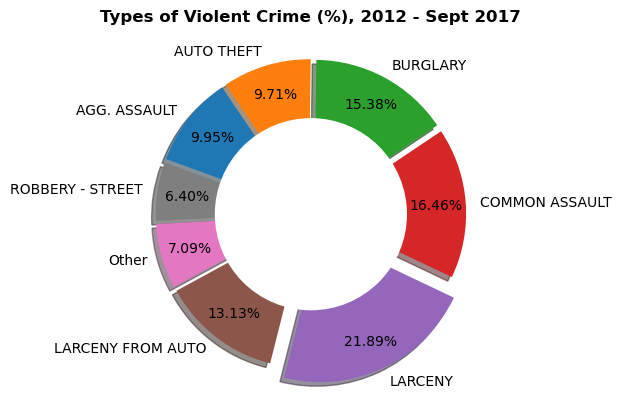

In [5]:
# pie chart of types of victim-based crime

# create temporary data frame of value counts for types of crime
desc_df = df.Description.value_counts()
desc_df = desc_df.to_frame().reset_index()
desc_df.rename(columns={"index": "Description", "Description": "count"}, inplace=True)

# condense small values into a single 'Other' category
small_values = (desc_df["count"] / len(df)) < 0.05
desc_df.loc[small_values, "Description"] = "Other"
desc_df = desc_df.groupby("Description")["count"].sum()

# plot the pie chart
plt.pie(
    desc_df.values,
    labels=desc_df.index,
    explode=(0.05, 0.05, 0.05, 0.05, 0.15, 0.05, 0.05, 0.05),
    shadow=True,
    startangle=160,
    autopct="%1.2f%%",
    pctdistance=0.8,
    counterclock=False,
)

plt.title("Types of Violent Crime (%), 2012 - Sept 2017", fontweight="bold")

# add a donut hole to the pie chart
# gcf - get current figure, gca - get current axis
donut = plt.Circle((0, 0), 0.65, facecolor="white")
plt.gcf().gca().add_artist(donut)

plt.show()

The panoramic view


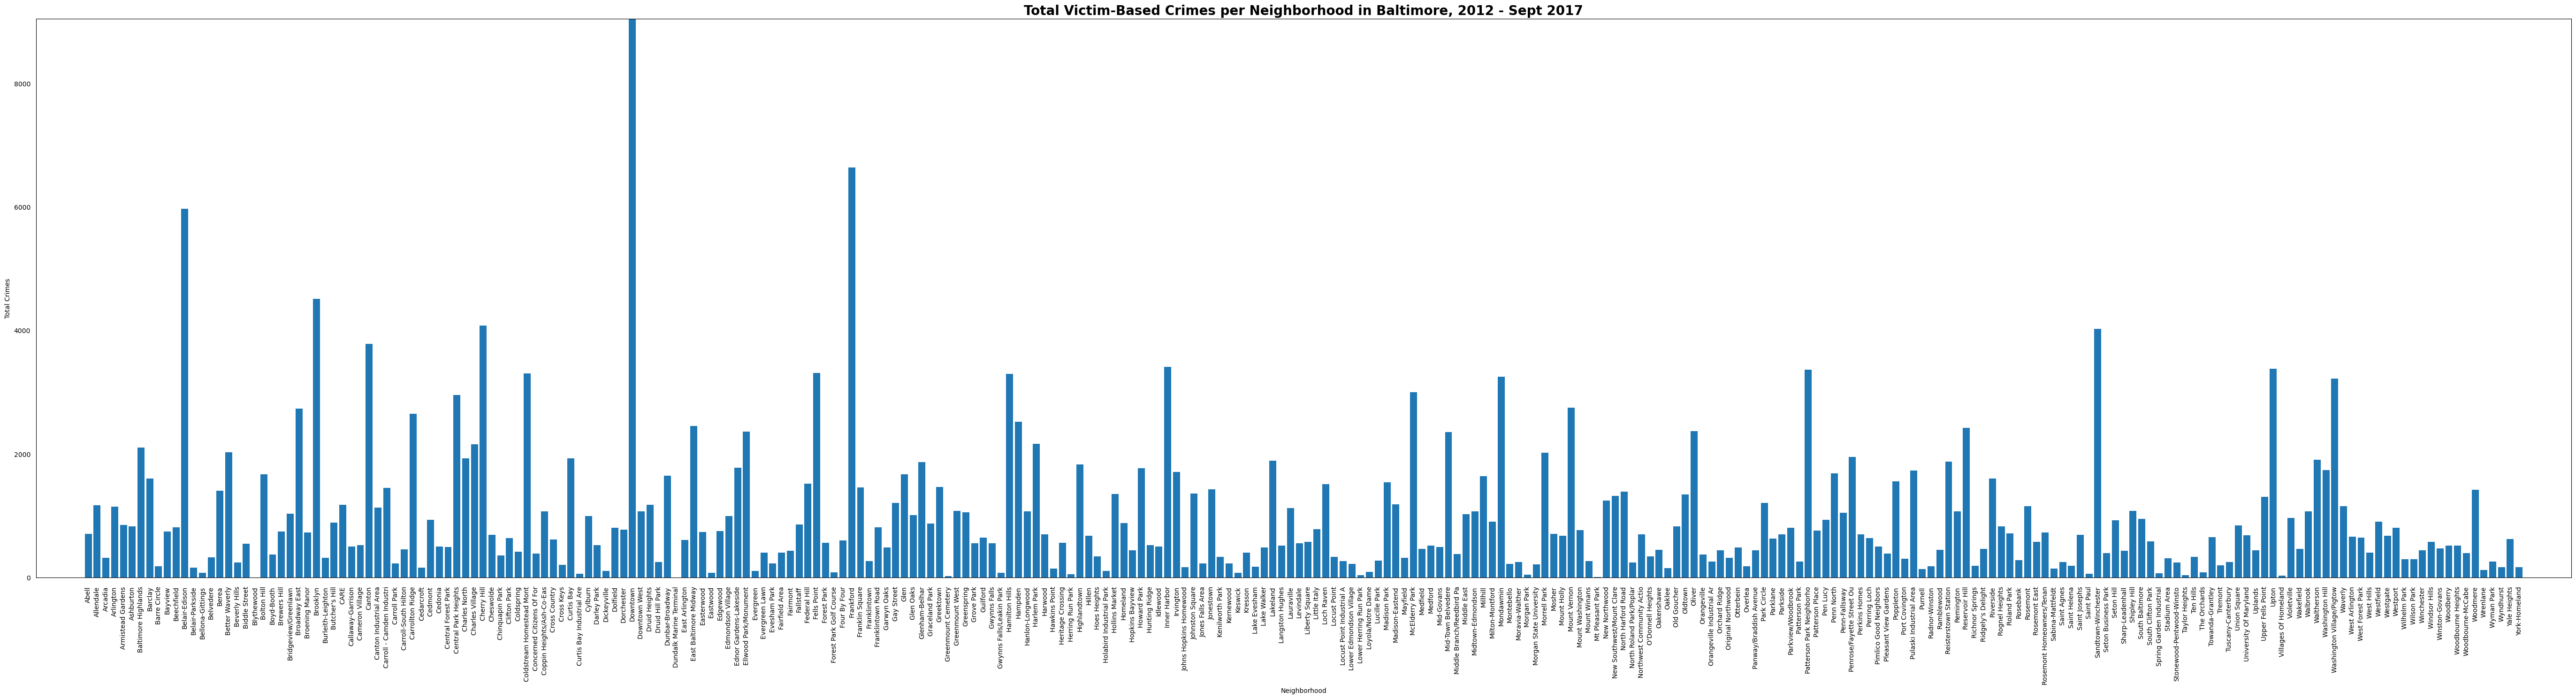

In [6]:
# calculate crime by neighborhood
crime_per_neighborhood = (
    df.groupby("Neighborhood").size().reset_index(name="Total_Crimes")
)

neighborhood = crime_per_neighborhood["Neighborhood"]
crime = crime_per_neighborhood["Total_Crimes"]

# create plot
fig, ax = plt.subplots(figsize=(55, 15))

# horizontal plot
ax.bar(neighborhood, crime)
plt.xticks(rotation=90)

# remove ticks
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=10)
ax.yaxis.set_tick_params(pad=5)

plt.margins(x=0.02, y=0)

print("The panoramic view")

# set labels
plt.xlabel("Neighborhood")
plt.ylabel("Total Crimes")
plt.title(
    "Total Victim-Based Crimes per Neighborhood in Baltimore, 2012 - Sept 2017",
    fontsize=20,
    fontweight="bold",
)
plt.tight_layout()

plt.show()

The long view


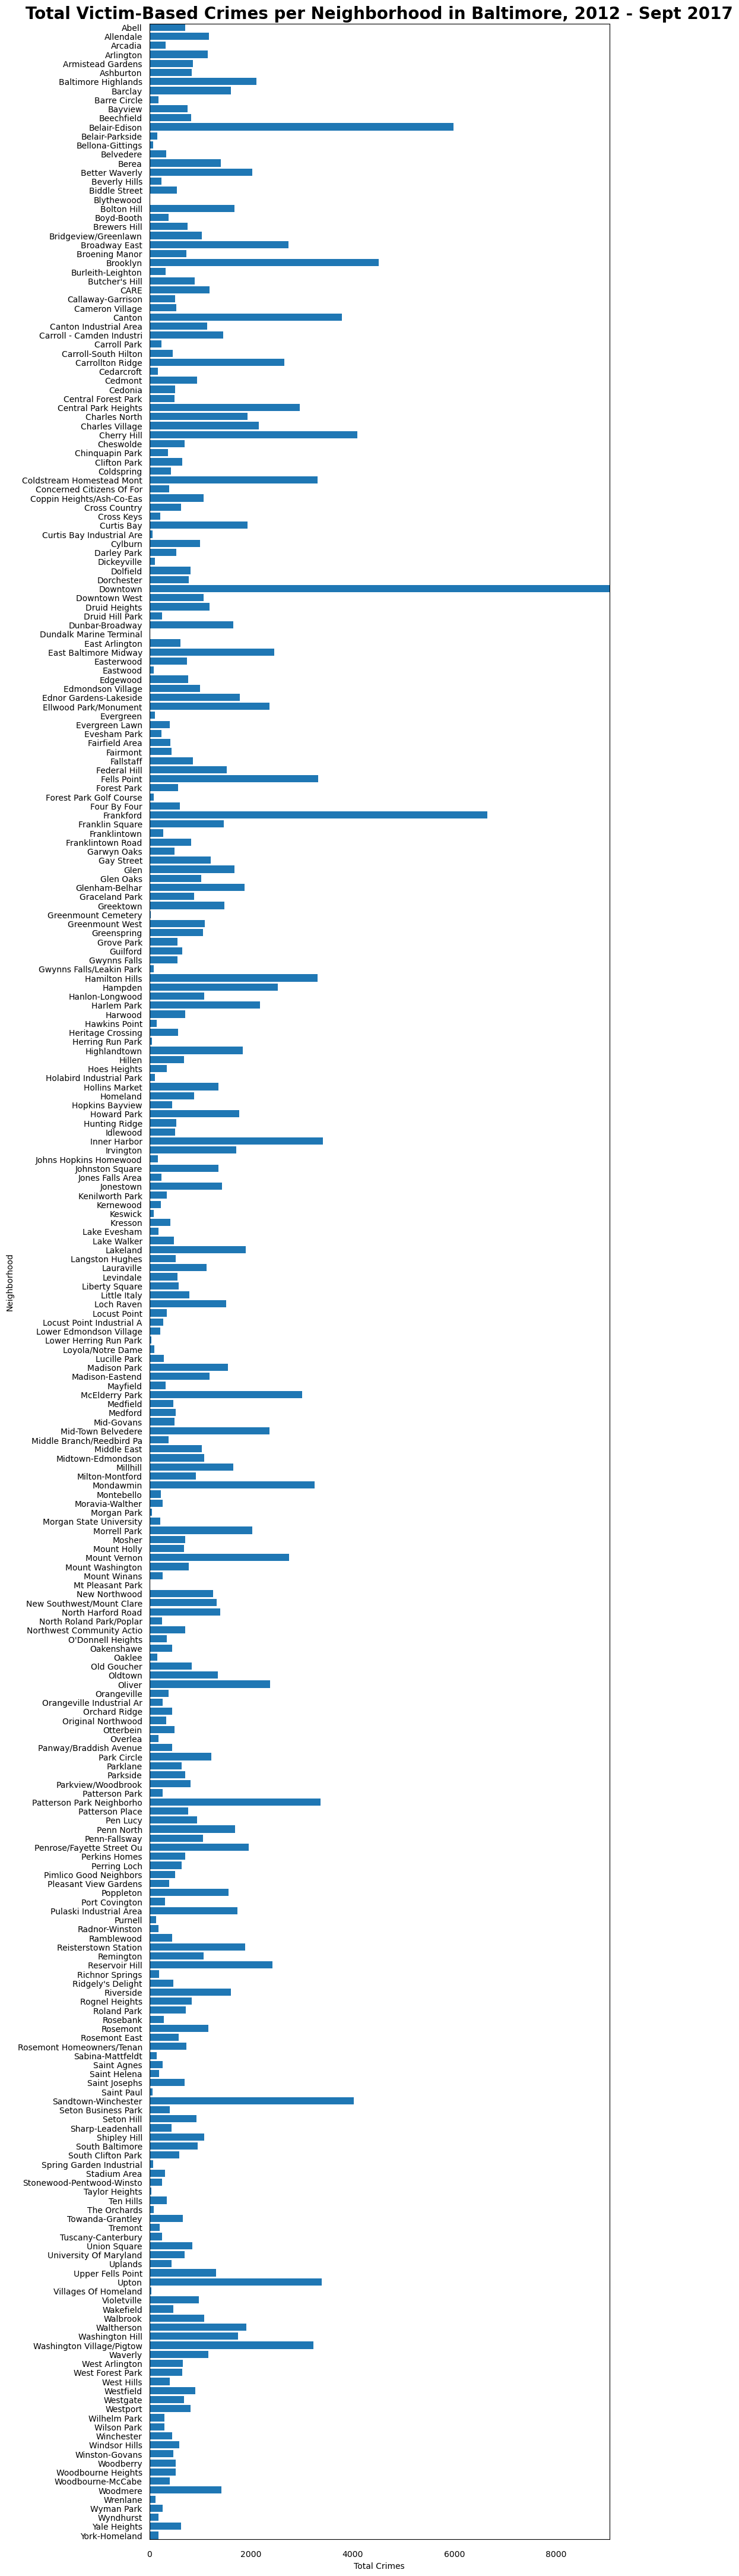

In [7]:
# calculate crime by neighborhood
crime_per_neighborhood = (
    df.groupby("Neighborhood").size().reset_index(name="Total_Crimes")
)

neighborhood = crime_per_neighborhood["Neighborhood"]
crime = crime_per_neighborhood["Total_Crimes"]

# create plot
fig, ax = plt.subplots(figsize=(10, 55))

# horizontal plot
ax.barh(neighborhood, crime)

# remove ticks
ax.xaxis.set_ticks_position("none")
ax.yaxis.set_ticks_position("none")

# Add padding between axes and labels
ax.xaxis.set_tick_params(pad=10)
ax.yaxis.set_tick_params(pad=5)

plt.margins(x=0, y=0)

# invert axis
ax.invert_yaxis()

print("The long view")

# set labels
plt.ylabel("Neighborhood")
plt.xlabel("Total Crimes")
plt.title(
    "Total Victim-Based Crimes per Neighborhood in Baltimore, 2012 - Sept 2017",
    fontsize=20,
    fontweight="bold",
)

plt.show()

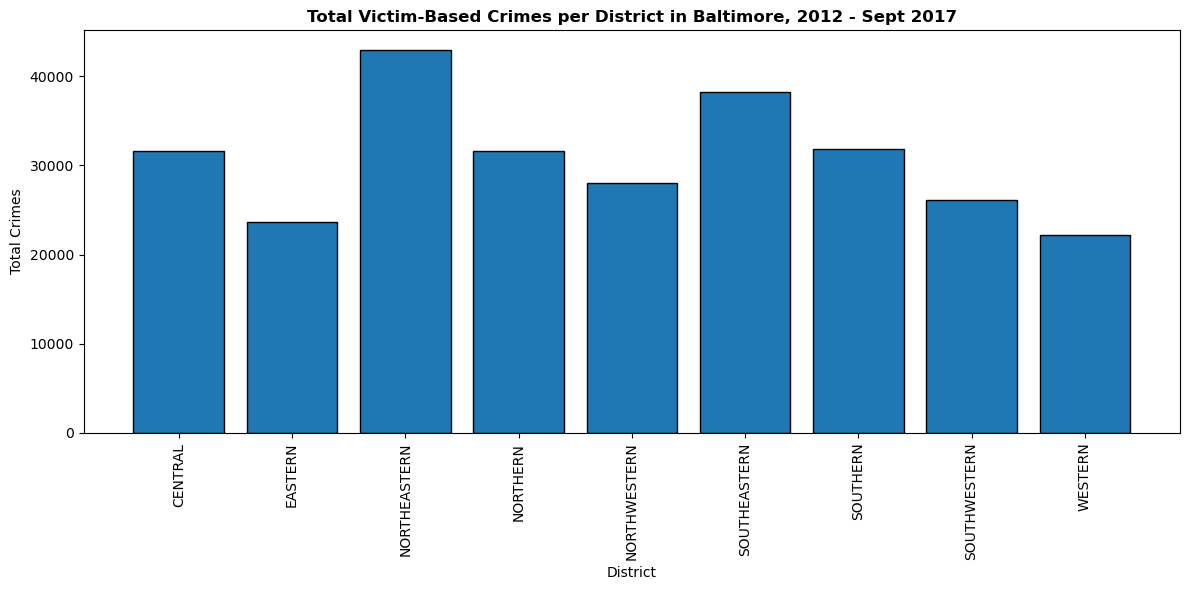

In [8]:
crime_per_District = df.groupby("District").size().reset_index(name="Total_Crimes")

plt.figure(figsize=(12, 6))
plt.bar(
    crime_per_District["District"],
    crime_per_District["Total_Crimes"],
    edgecolor="black",
)
plt.xlabel("District")
plt.ylabel("Total Crimes")
plt.title(
    "Total Victim-Based Crimes per District in Baltimore, 2012 - Sept 2017",
    fontweight="bold",
)
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [9]:
# create data frame of crime per district for 2012-2016
crime_dis = (
    df[df.CrimeDate.dt.year < 2017]
    .groupby([df.CrimeDate.dt.year, "District"])
    .size()
    .unstack()
)
crime_dis

District,CENTRAL,EASTERN,NORTHEASTERN,NORTHERN,NORTHWESTERN,SOUTHEASTERN,SOUTHERN,SOUTHWESTERN,WESTERN
CrimeDate,,,,,,,,,
2012,6496,4235,7728,5586,4886,6580,5796,4440,3812
2013,5656,4135,7838,5741,5324,6983,5581,4265,4035
2014,5034,3661,7513,5320,4703,6427,5213,4357,3728
2015,5317,4098,7723,5948,4778,7105,5224,4620,4007
2016,5700,4275,6882,5409,4937,6686,6001,4767,4079


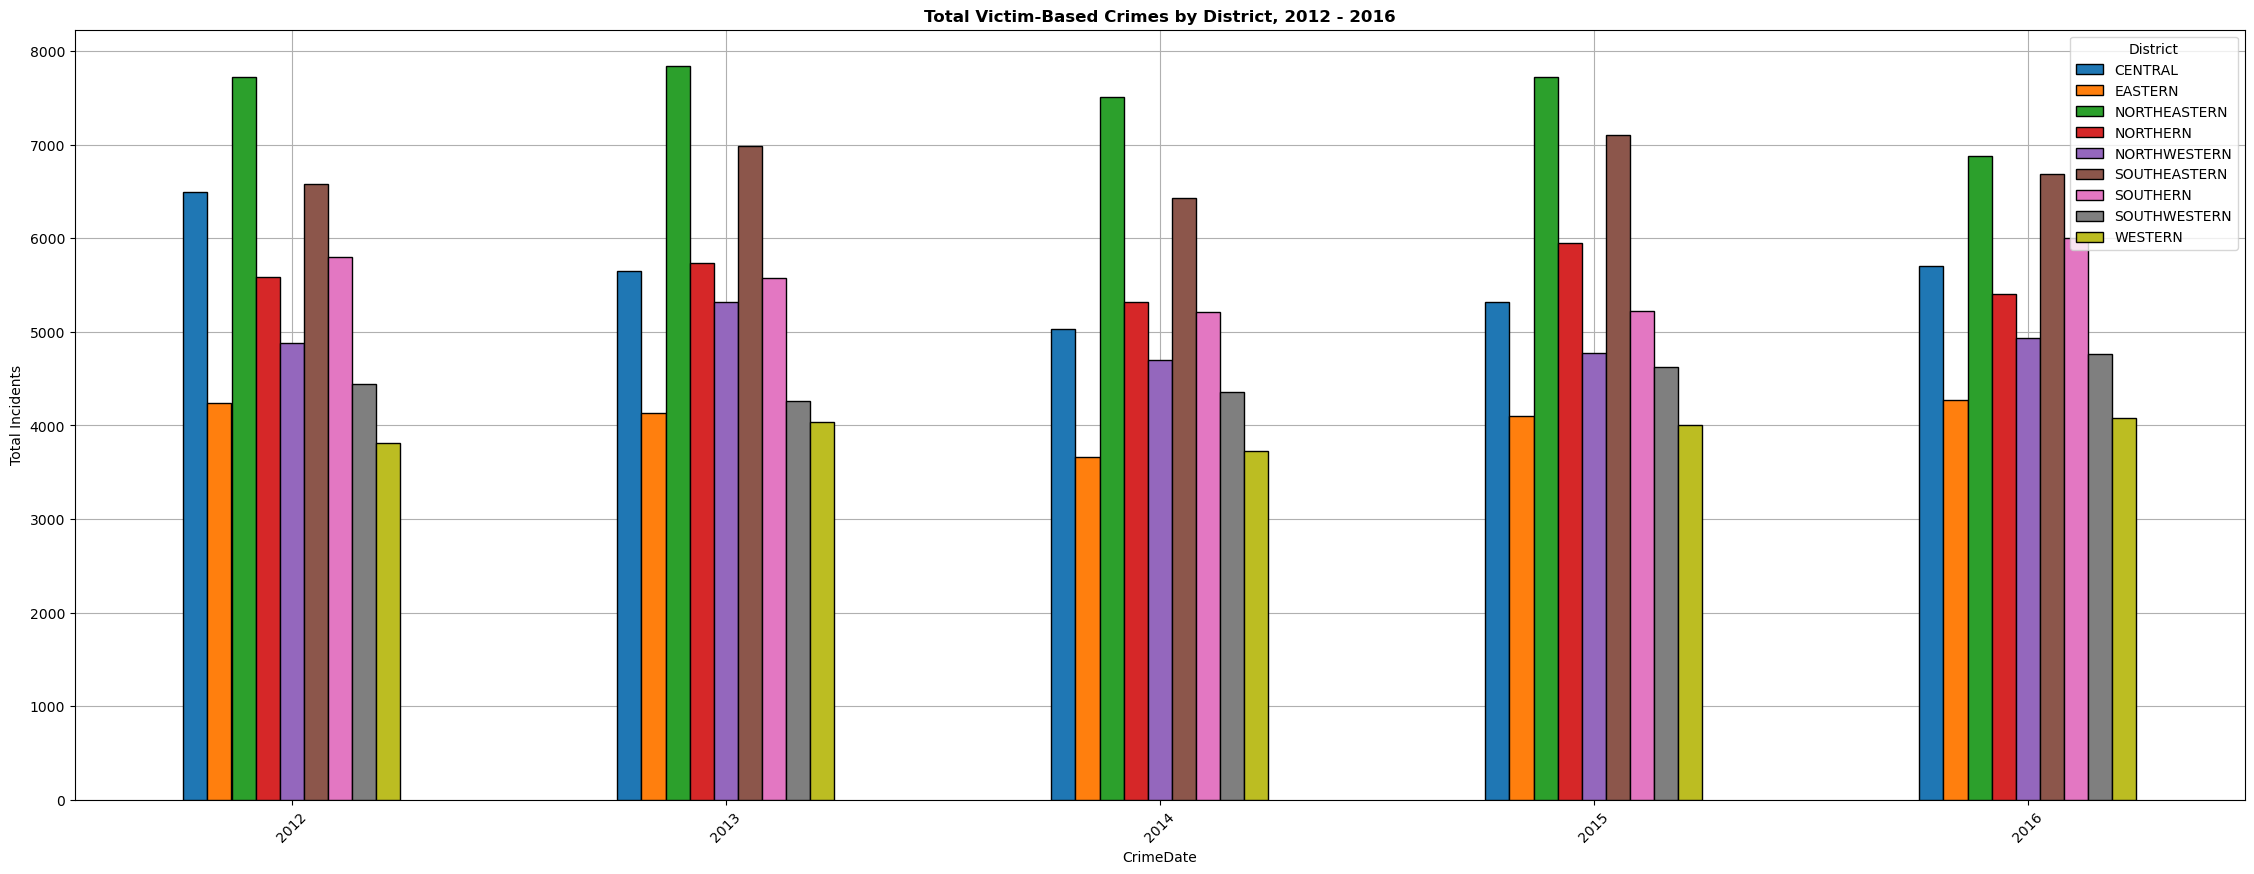

In [10]:
# plot chart of 2012-2016 crimes per district
crime_dis.plot(kind="bar", figsize=(28, 10), edgecolor="black", zorder=3)

# formatting
plt.title("Total Victim-Based Crimes by District, 2012 - 2016", fontweight="bold")
plt.ylabel("Total Incidents")
plt.grid()
plt.grid(zorder=0)
plt.xticks(rotation=45)

plt.show()

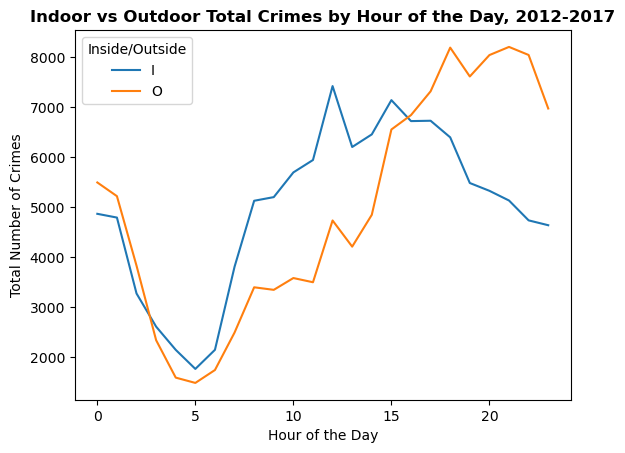

In [11]:
# temporary data frame
pre2017_df = df[df["CrimeDate"].dt.year < 2017].copy()
pre2017_df["CrimeTimeTemp"] = pd.to_datetime(pre2017_df.CrimeTime, format="%H:%M:%S")

# unstack pivots the table
_ = (
    pre2017_df.groupby([pre2017_df["CrimeTimeTemp"].dt.hour, "Inside/Outside"])
    .size()
    .unstack()
)

# plot the chart
_.plot(kind="line")
plt.title(
    "Indoor vs Outdoor Total Crimes by Hour of the Day, 2012-2017", fontweight="bold"
)
plt.xlabel("Hour of the Day")
plt.ylabel("Total Number of Crimes")

plt.show()

## Outlier - The Death of Freddie Gray

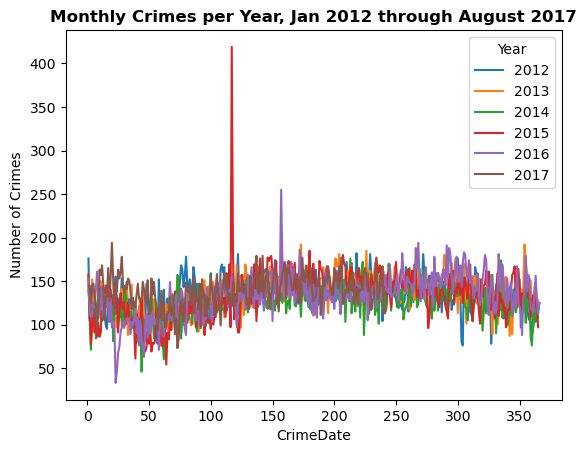

The giant spike in 2015 is the protests following the death of Freddie Gray.

Day 157 of 2016 is 5 June 2016, according to the internet.
But further research is needed to find out what happened around that day.
Could be a fluke, but outlier is more descriptive.


In [12]:
# huge outlier - Freddie Gray

year_df = df.copy()
year_df["Year"] = year_df.CrimeDate.dt.year
year_df["Month"] = year_df.CrimeDate.dt.month
year_df["Day"] = year_df.CrimeDate.dt.year
year_df = year_df[year_df.CrimeDate < "2017-09-01"]

_ = year_df.groupby(year_df.CrimeDate.dt.dayofyear)["Year"].value_counts().unstack()
_.plot(kind="line")

# Format the plot
plt.ylabel("Number of Crimes")
plt.title("Monthly Crimes per Year, Jan 2012 through August 2017", fontweight="bold")

plt.savefig("Images/outlier.png")

plt.show()

print(
    f"""The giant spike in 2015 is the protests following the death of Freddie Gray.

Day {_[2016].idxmax()} of 2016 is 5 June 2016, according to the internet.
But further research is needed to find out what happened around that day.
Could be a fluke, but outlier is more descriptive."""
)

## Type of Crime per Hour

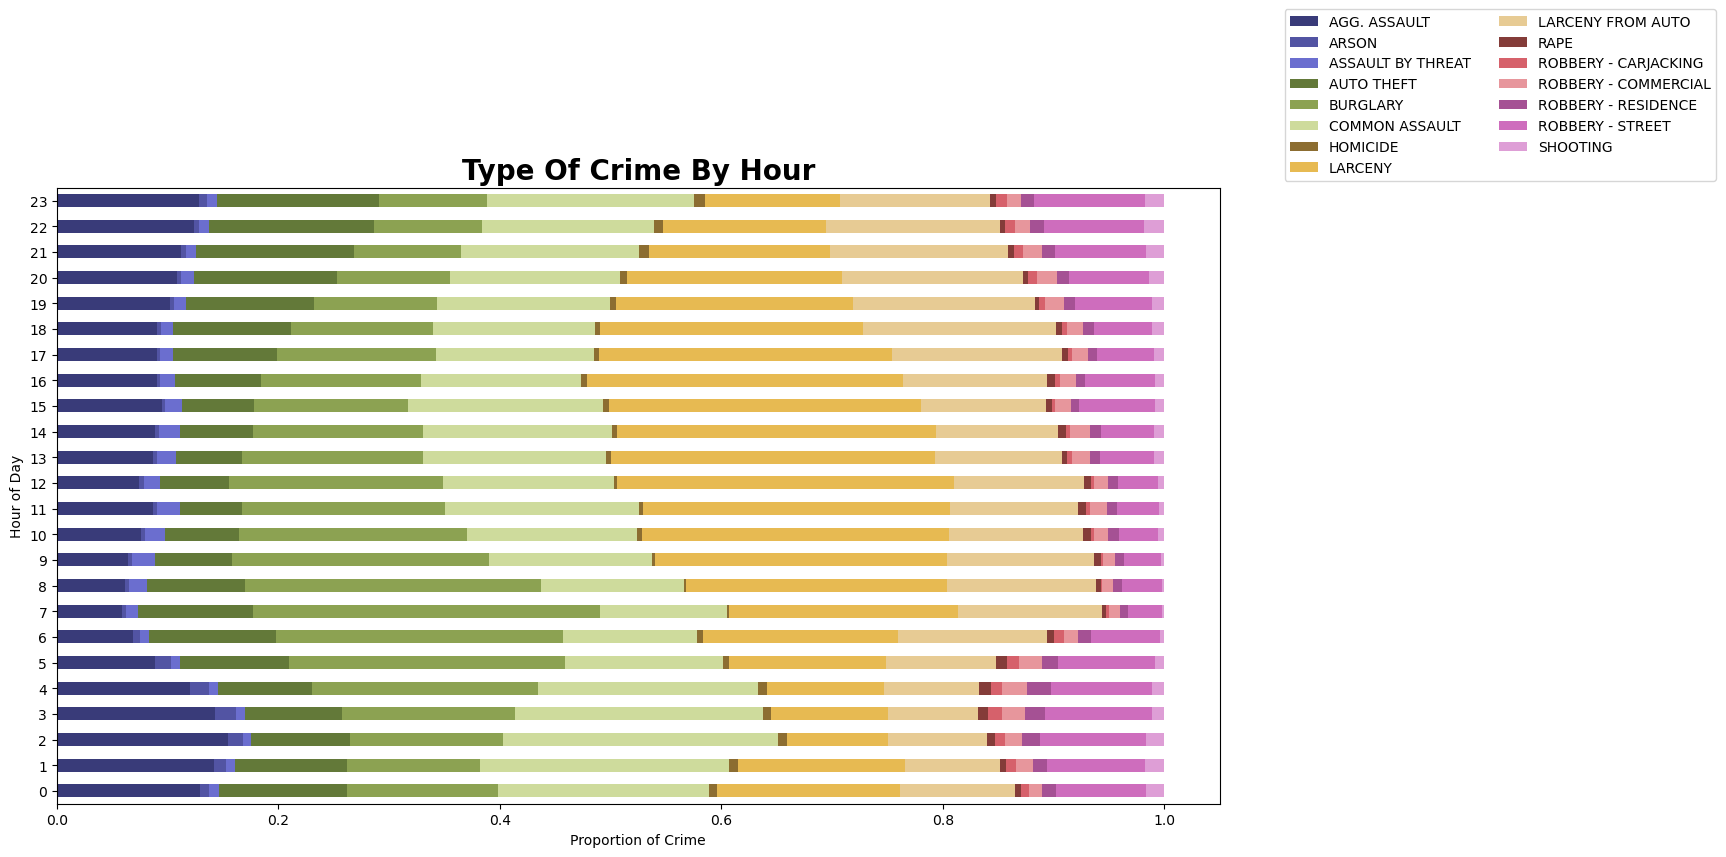

In [13]:
crime_type = df["Description"]
hour_of_day = df.CrimeTime.str[:2].astype(int)

crime_type_by_hour_df = pd.DataFrame(
    {
        "Type of Crime": crime_type,
        "Hour of Day": hour_of_day,
    }
)

# create 100% stacked chart to show proportions of different types of crime per hour of day

# cross tabulation proportions
cross_tab_prop = pd.crosstab(
    index=crime_type_by_hour_df["Hour of Day"],
    columns=crime_type_by_hour_df["Type of Crime"],
    normalize="index",
)

cross_tab_prop.plot(kind="barh", stacked=True, colormap="tab20b", figsize=(15, 8))
plt.legend(bbox_to_anchor=(1.05, 1), loc="lower left", ncol=2)
plt.title("Type Of Crime By Hour", fontsize=20, fontweight="bold")
plt.ylabel("Hour of Day")
plt.xlabel("Proportion of Crime")

plt.savefig("Images/type_per_hour.png")

plt.show()

In [14]:
# Convert the data into a contingency table with frequencies
contingency = pd.crosstab(
    crime_type_by_hour_df["Type of Crime"], crime_type_by_hour_df["Hour of Day"]
)
contingency

Hour of Day,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Type of Crime,,,,,,,,,,,,,,,,,,,,,
AGG. ASSAULT,1644,1604,1267,812,523,336,308,422,593,631,...,1163,1483,1405,1469,1513,1548,1658,1726,1837,1733
ARSON,109,118,105,111,72,53,30,24,35,36,...,41,42,43,38,58,59,65,70,74,94
ASSAULT BY THREAT,110,93,60,46,35,32,37,77,161,214,...,249,242,213,191,178,167,172,138,132,119
AUTO THEFT,1468,1139,735,499,371,375,516,750,858,689,...,867,1007,1204,1525,1784,1754,1988,2191,2221,1977
BURGLARY,1739,1361,1129,891,886,945,1170,2253,2582,2294,...,2014,2177,2249,2321,2139,1685,1567,1494,1451,1316
COMMON ASSAULT,2430,2538,2036,1276,865,541,545,826,1256,1463,...,2241,2753,2239,2314,2448,2367,2355,2480,2309,2514
HOMICIDE,92,91,69,44,36,21,26,15,14,25,...,57,85,77,72,77,79,97,133,123,137
LARCENY,2104,1706,742,603,456,537,792,1487,2279,2612,...,3776,4398,4436,4285,3973,3254,2972,2516,2185,1639
LARCENY FROM AUTO,1332,975,732,462,375,377,608,930,1308,1314,...,1446,1755,2026,2481,2913,2491,2511,2486,2339,1829


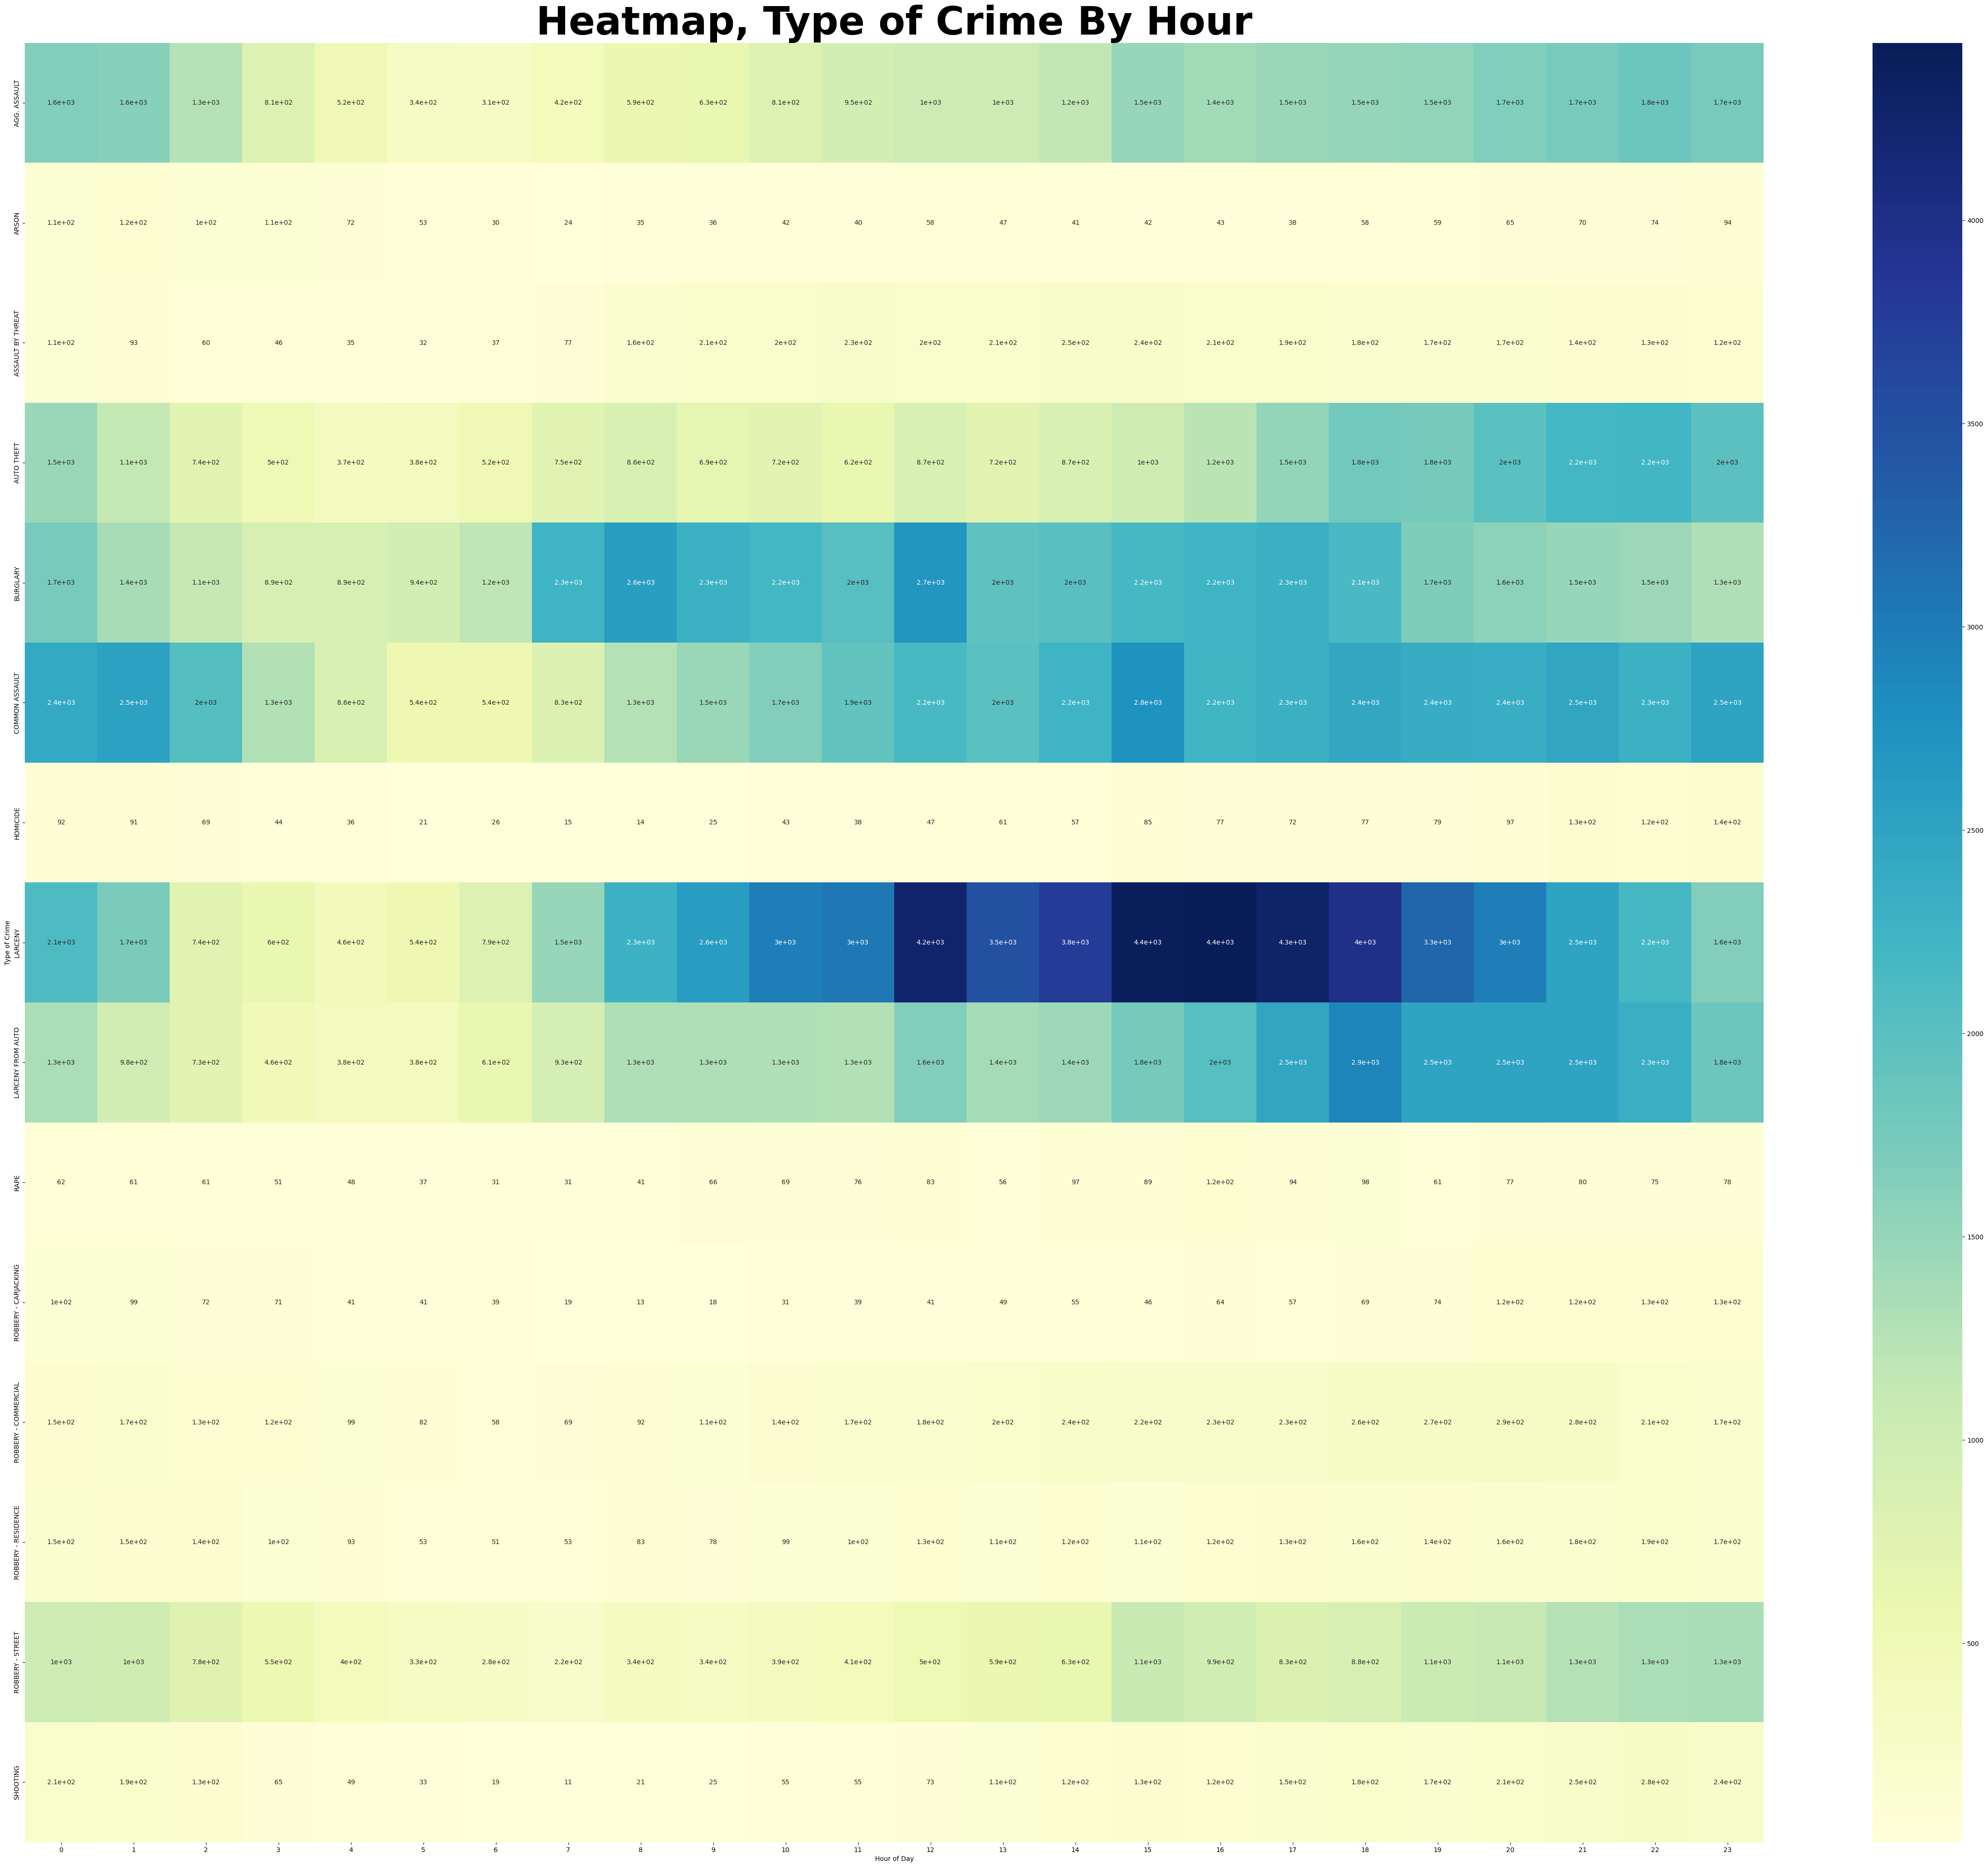

In [15]:
# Contingency tables are visually easier as heatmaps
plt.figure(figsize=(60, 50))
plt.title("Heatmap, Type of Crime By Hour", size=60, fontweight="bold")
sns.heatmap(contingency, annot=True, cmap="YlGnBu")
plt.show()

## Chi-square

The chi square statistic is large, and the pvalue zero, indicating there is a strong statistical association between the frequency of crimes and the two categorical variables of Type of Crime and Hour of the Day.

In [16]:
# Chi-square test of independence.
c, p, dof, expected = st.chi2_contingency(contingency)
# Print the p-value
print(f"p-value =", p)

p-value = 0.0


In [17]:
# chi square
_ = pd.crosstab(
    crime_type_by_hour_df["Type of Crime"], crime_type_by_hour_df["Hour of Day"]
)
print(
    f"""Chi-square test:

{st.chisquare(_)}

Chi-square contingency:

{st.chi2_contingency(_)}"""
)

Chi-square test:

Power_divergenceResult(statistic=array([12224.32810047, 11480.40240772,  8938.03297911,  5509.42766965,
        4224.53624856,  4102.27833421,  5847.40354767, 12922.12100139,
       15733.37809917, 15838.73085074, 16590.41108416, 16600.03314817,
       23465.75740661, 18048.00465658, 19010.40896615, 22095.47166186,
       21548.56295057, 21386.13631313, 20281.3193016 , 16453.93278418,
       15242.26469438, 14318.84996429, 13328.90780809, 12086.68991098]), pvalue=array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0.]))

Chi-square contingency:

Chi2ContingencyResult(statistic=21795.529007088917, pvalue=0.0, dof=322, expected_freq=array([[1267.55465069, 1123.98468515,  814.5580789 ,  567.41477024,
         432.30180198,  377.48056081,  448.71832611,  715.36247555,
         963.10274872,  985.88689432, 1066.37760958, 1092.5445541 ,
        1390.33035233, 1196.51587356, 1304.96442688, 1553.60014682,
        1545.7401

In [18]:
print(
    """The chi square statistics indicate there is a strong statistical association between the frequency of crimes, 
and the two categorical variables of Type of Crime and Hour of the Day.
"""
)

The chi square statistics indicate there is a strong statistical association between the frequency of crimes, 
and the two categorical variables of Type of Crime and Hour of the Day.



## Crime per Time of Day

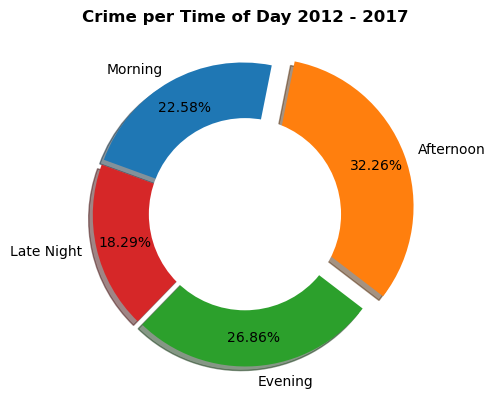

In [19]:
crime_tod = df["Time of Day"].value_counts()
crime_tod = crime_tod.reindex(["Morning", "Afternoon", "Evening", "Late Night"])

plt.pie(
    crime_tod.values,
    labels=crime_tod.index,
    explode=(0.03, 0.15, 0.03, 0.03),
    shadow=True,
    startangle=160,
    autopct="%1.2f%%",
    pctdistance=0.8,
    counterclock=False,
)

plt.title("Crime per Time of Day 2012 - 2017", fontweight="bold")

# gcf get current figure, gca get current axis
donut = plt.Circle((0, 0), 0.65, facecolor="white")
plt.gcf().gca().add_artist(donut)

plt.savefig("Images/per_time_of_day.png")

plt.show()

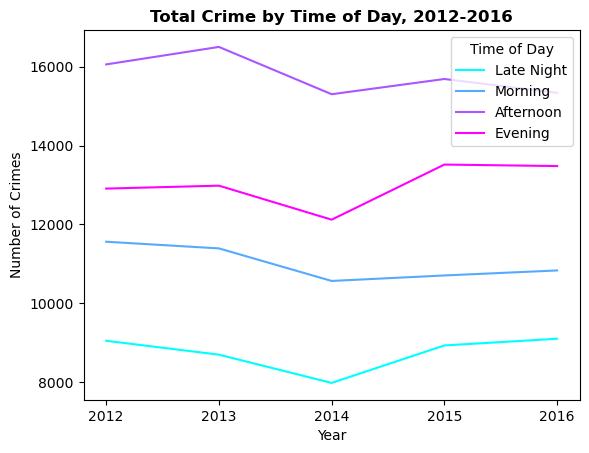

In [20]:
# temporary data frame dropping 2017 (which ends September 2nd, skewing totals)
pre2017_df = df[df.CrimeDate.dt.year < 2017]

# unstack pivots the table
x = pre2017_df.groupby([pre2017_df.CrimeDate.dt.year, "Time of Day"]).size().unstack()

# plot and format
x.plot(kind="line", cmap=plt.colormaps.get_cmap("cool"))
plt.title("Total Crime by Time of Day, 2012-2016", fontweight="bold")
plt.xticks(x.index.astype(int))
plt.xlabel("Year")
plt.ylabel("Number of Crimes")
plt.show()

In [21]:
time_of_day = (
    df[df.CrimeDate.dt.year < 2017]
    .groupby([df.CrimeDate.dt.year, "Time of Day"])
    .size()
    .unstack()
)
time_of_day = time_of_day.reindex(
    columns=["Morning", "Afternoon", "Evening", "Late Night"]
)
print("Table of number of crimes per year, cateogrized by time of day.")
time_of_day

Table of number of crimes per year, cateogrized by time of day.


Time of Day,Morning,Afternoon,Evening,Late Night
CrimeDate,,,,
2012,11561,16056,12908,9050
2013,11392,16499,12982,8698
2014,10567,15300,12120,7982
2015,10706,15686,13517,8932
2016,10833,15335,13479,9102


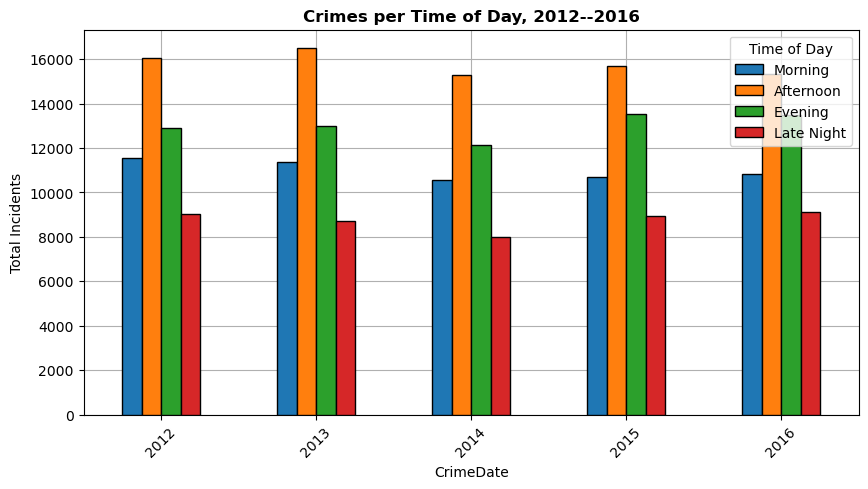

In [22]:
# Plot stacked bar graph
time_of_day.plot(kind="bar", figsize=(10, 5), edgecolor="black", zorder=3)
plt.title("Crimes per Time of Day, 2012--2016", fontweight="bold")
plt.ylabel("Total Incidents")
plt.grid()
plt.grid(zorder=0)
plt.xticks(rotation=45)
plt.show()

## ANOVA

The number of victim-based crimes occuring is impacted by time of day, according to the extremely small pvalue.

In [23]:
# ANOVA
pre2017_df = df[df["CrimeDate"].dt.year < 2017]

# group populations by time of day category
m = (
    pre2017_df[pre2017_df["Time of Day"] == "Morning"]
    .groupby(pre2017_df["CrimeDate"].dt.year)
    .size()
)
a = (
    pre2017_df[pre2017_df["Time of Day"] == "Afternoon"]
    .groupby(pre2017_df["CrimeDate"].dt.year)
    .size()
)
e = (
    pre2017_df[pre2017_df["Time of Day"] == "Evening"]
    .groupby(pre2017_df["CrimeDate"].dt.year)
    .size()
)
n = (
    pre2017_df[pre2017_df["Time of Day"] == "Late Night"]
    .groupby(pre2017_df["CrimeDate"].dt.year)
    .size()
)

print(
    f"""{st.f_oneway(m, a, e, n)}
Note the extremely small pvalue. Crime is impacted by the time of day"""
)

F_onewayResult(statistic=181.68417620148915, pvalue=1.4417942015211965e-12)
Note the extremely small pvalue. Crime is impacted by the time of day


## Crime per Hour per Day of the Week

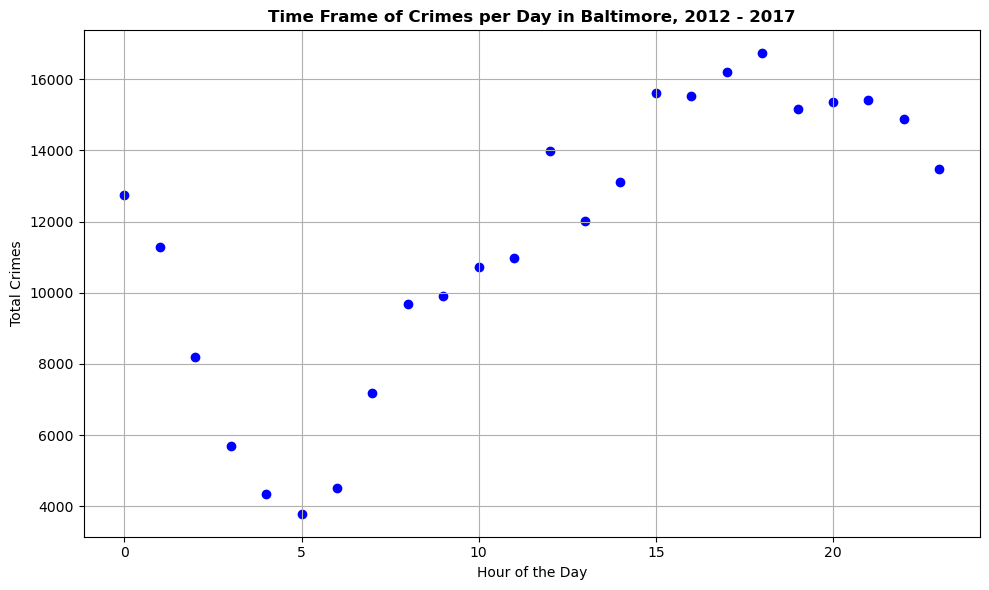

In [24]:
crime_by_hour = df.copy()
crime_by_hour["Hour"] = df.CrimeTime.str[:2].astype(int)

crime_by_hour = crime_by_hour.groupby("Hour").size().reset_index(name="Total_Crimes")

plt.figure(figsize=(10, 6))
plt.scatter(crime_by_hour["Hour"], crime_by_hour["Total_Crimes"], marker="o", color="b")
plt.xlabel("Hour of the Day")
plt.ylabel("Total Crimes")
plt.title("Time Frame of Crimes per Day in Baltimore, 2012 - 2017", fontweight="bold")
plt.grid(True)
plt.tight_layout()
plt.show()

The slope for Sunday is 40.587826086956525
The r-value is 0.4977664036358951
The pvalue is 0.013317812491476167
-----
The slope for Monday is 65.98130434782608
The r-value is 0.7599378235525983
The pvalue is 1.64674638973244e-05
-----
The slope for Tuesday is 68.78478260869565
The r-value is 0.7868991613438004
The pvalue is 5.09180748886111e-06
-----
The slope for Wednesday is 67.75999999999999
The r-value is 0.7783972560799419
The pvalue is 7.501013011413863e-06
-----
The slope for Thursday is 65.79434782608695
The r-value is 0.7730847128748713
The pvalue is 9.475650440040368e-06
-----
The slope for Friday is 74.30956521739131
The r-value is 0.7913580178198913
The pvalue is 4.126687464296085e-06
-----
The slope for Saturday is 48.11217391304348
The r-value is 0.581917220173801
The pvalue is 0.002854172971297055
-----
The pvalue is well below .05, signifying a statistical correlation between time of day and the number of victim-based crimes.
The rvalue is also high, at least .5, and of

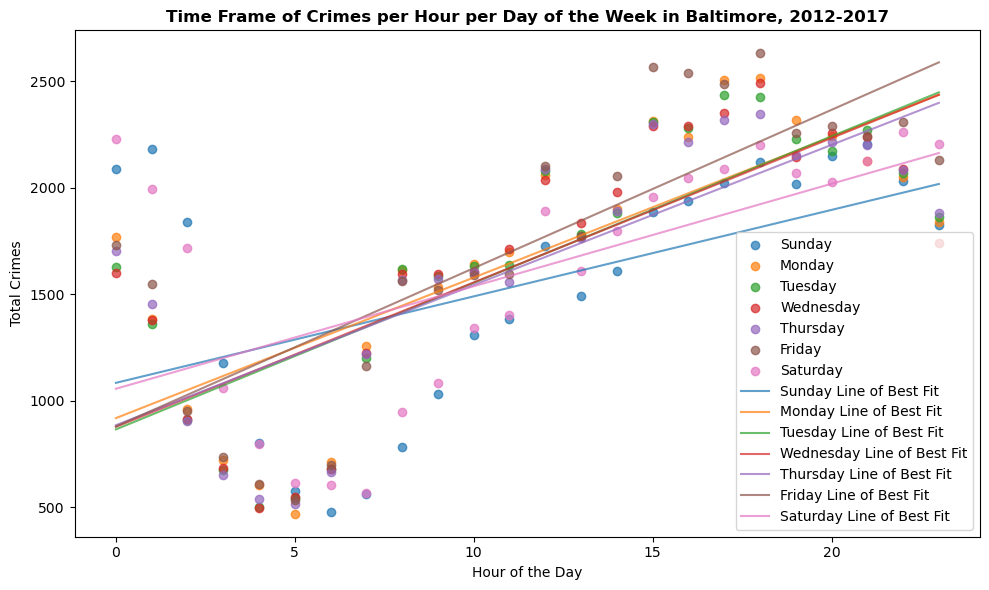

In [25]:
# plot the same chart above, but for every day of the week

df["CrimeTime"] = pd.to_datetime(df["CrimeTime"])
df["Hour"] = df["CrimeTime"].dt.hour

crime_by_hour = (
    df.groupby(["Day of Week", "Hour"]).size().reset_index(name="Total_Crimes")
)

# List of days of the week in the desired order
days_of_week_order = [
    "Sunday",
    "Monday",
    "Tuesday",
    "Wednesday",
    "Thursday",
    "Friday",
    "Saturday",
]

plt.figure(figsize=(10, 6))

# Iterate through each day of the week and plot the scatter points for that day
for day in days_of_week_order:
    day_data = crime_by_hour[crime_by_hour["Day of Week"] == day]
    plt.scatter(
        day_data["Hour"], day_data["Total_Crimes"], marker="o", label=day, alpha=0.7
    )

# Calculate the line of best fit using numpy's polyfit
for day in days_of_week_order:
    day_data = crime_by_hour[crime_by_hour["Day of Week"] == day]
    coef = np.polyfit(day_data["Hour"], day_data["Total_Crimes"], 1)
    plt.plot(
        day_data["Hour"],
        np.polyval(coef, day_data["Hour"]),
        label=f"{day} Line of Best Fit",
        alpha=0.7,
    )
    lr = st.linregress(day_data.Hour, day_data["Total_Crimes"])
    tmp = lr[0] * day_data.Hour + lr[1]
    # plt.plot(day_data.Hour, tmp)
    print(
        f"""The slope for {day} is {lr.slope}
The r-value is {lr.rvalue}
The pvalue is {lr.pvalue}
-----"""
    )

print(
    """The pvalue is well below .05, signifying a statistical correlation between time of day and the number of victim-based crimes.
The rvalue is also high, at least .5, and often close to .8, meaning the scatter points fit the line relatively well."""
)

plt.xlabel("Hour of the Day")
plt.ylabel("Total Crimes")
plt.title(
    "Time Frame of Crimes per Hour per Day of the Week in Baltimore, 2012-2017",
    fontweight="bold",
)
plt.legend()
plt.tight_layout()

plt.savefig("Images/per_hour_per_weekday.png")

plt.show()

## Linear Regression

The pvalue is well below .05, signifying a statistical correlation between time of day and the number of victim-based crimes.
The rvalue is also high, at least .5, and often close to .8, meaning the scatter points fit the line relatively well.

The linear regression line shows how the value of a scatter point on the y-axis can be predicted by the value on the x-axis. The r-value measures how closely the scatter points fit the line, on a scale of -1 to 1, with zero meaning no relationship between the scatter points and the slope of the line, and an absolute value of 1 meaning an exact fit between the line and the points. So, an r-value close to 1 or -1 means the line detects a significant relationship between the x & y axis. An r-value close to zero signifies the line has no bearing on the relationship between the x & y axis.

## Crime by Day of Week


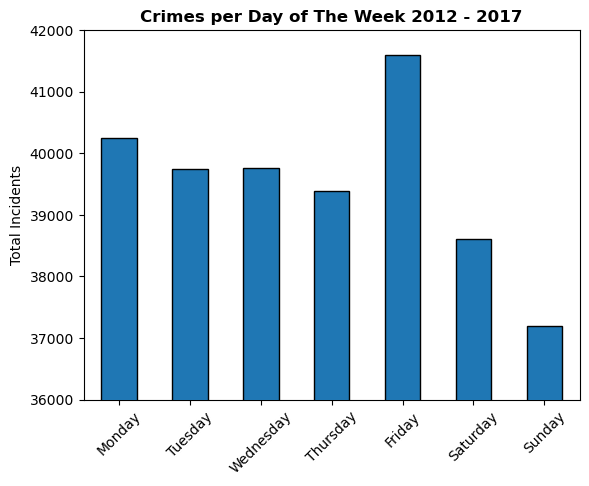

In [26]:
crime_tod = df["Day of Week"].value_counts()
crime_tod = crime_tod.reindex(
    ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
)
crime_tod.plot.bar(edgecolor="black", zorder=3)
plt.title("Crimes per Day of The Week 2012 - 2017", fontweight="bold")
plt.ylabel("Total Incidents")
plt.xticks(rotation=45)
plt.ylim(36000, 42000)


plt.savefig("Images/per_weekday.png")

plt.show()

Friday has the highest percentage of crimes. Sunday the lowest.


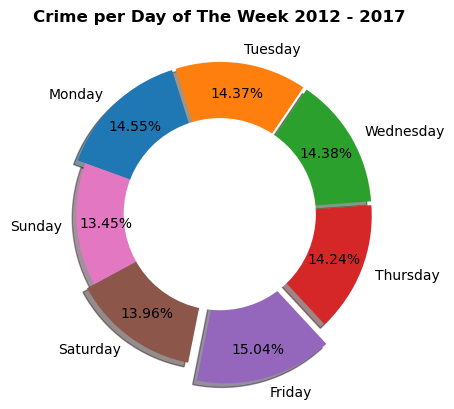

In [27]:
plt.pie(
    crime_tod.values,
    labels=crime_tod.index,
    explode=(0.03, 0.03, 0.03, 0.03, 0.15, 0.03, -0.03),
    shadow=True,
    startangle=160,
    autopct="%1.2f%%",
    pctdistance=0.8,
    counterclock=False,
)

print("Friday has the highest percentage of crimes. Sunday the lowest.")

plt.title("Crime per Day of The Week 2012 - 2017", fontweight="bold")

# gcf get current figure, gca get current axis
donut = plt.Circle((0, 0), 0.65, facecolor="white")
plt.gcf().gca().add_artist(donut)

plt.show()

In [28]:
# create data frame of total crimes per day per year, dropping 2017
day_of_week = (
    df[df.CrimeDate.dt.year < 2017]
    .groupby([df["CrimeDate"].dt.year, "Day of Week"])
    .size()
    .unstack()
)
day_of_week = day_of_week.reindex(
    columns=[
        "Monday",
        "Tuesday",
        "Wednesday",
        "Thursday",
        "Friday",
        "Saturday",
        "Sunday",
    ]
)
day_of_week

Day of Week,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
CrimeDate,,,,,,,
2012,7044,6929,7115,6958,7539,7149,6841
2013,7128,7160,7162,7119,7502,6921,6579
2014,6822,6465,6619,6481,6955,6460,6167
2015,7318,7234,6908,7036,7188,6715,6442
2016,7065,7131,7043,6925,7349,6644,6592


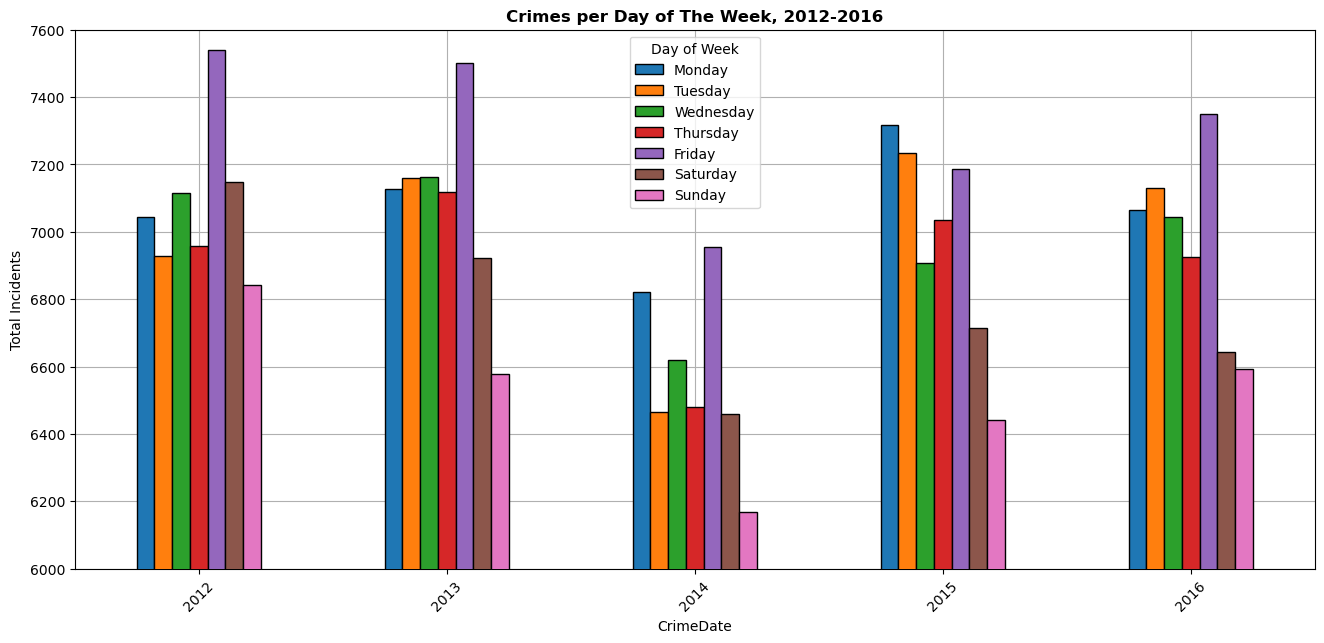

In [29]:
# plot crimes per day of the week per year
day_of_week.plot(kind="bar", figsize=(16, 7), edgecolor="black", zorder=3)

# formatting
plt.title("Crimes per Day of The Week, 2012-2016", fontweight="bold")
plt.ylabel("Total Incidents")
plt.grid()
plt.grid(zorder=0)
plt.xticks(rotation=45)
plt.ylim(6000, 7600)

plt.show()

## Chi-Square

The chi square statistics is quite large, and the pvalue effectively zero, indicating there is a strong statistical association between the frequency of crimes and the two categorical variables of time of day and day of the week.

In [30]:
# chi square
_ = pd.crosstab(pre2017_df["Time of Day"], pre2017_df["Day of Week"])
print(
    f"""{_}


Chi square test:

{st.chisquare(_)}

Chisquare contingency:

{st.chi2_contingency(_)}

------

The chi square statistic(s) is(are) quite large, and the pvalue(s) effectively zero, 
indicating there is a strong statistical association between the frequency of crimes 
and the two categorical variables of time of day and day of the week.
"""
)

Day of Week  Friday  Monday  Saturday  Sunday  Thursday  Tuesday  Wednesday
Time of Day                                                                
Late Night     5842    5768      7832    8039      5501     5383       5399
Morning        8433    8605      6339    5973      8450     8636       8623
Afternoon     12393   11708     10356    9707     11405    11599      11708
Evening        9865    9296      9362    8902      9163     9301       9117


Chi square test:

Power_divergenceResult(statistic=array([2461.78575534, 2026.81931764, 1097.80102688,  949.24039729,
       2063.53078015, 2264.49173802, 2309.97569375]), pvalue=array([0.00000000e+000, 0.00000000e+000, 1.09177424e-237, 1.84565997e-205,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000]))

Chisquare contingency:

Chi2ContingencyResult(statistic=2679.7751310903027, pvalue=0.0, dof=18, expected_freq=array([[ 6587.54542346,  6379.0981974 ,  6110.78550504,  5882.14269999,
         6224.38563688,  6296.51270472,  6283

## Crime over the Year


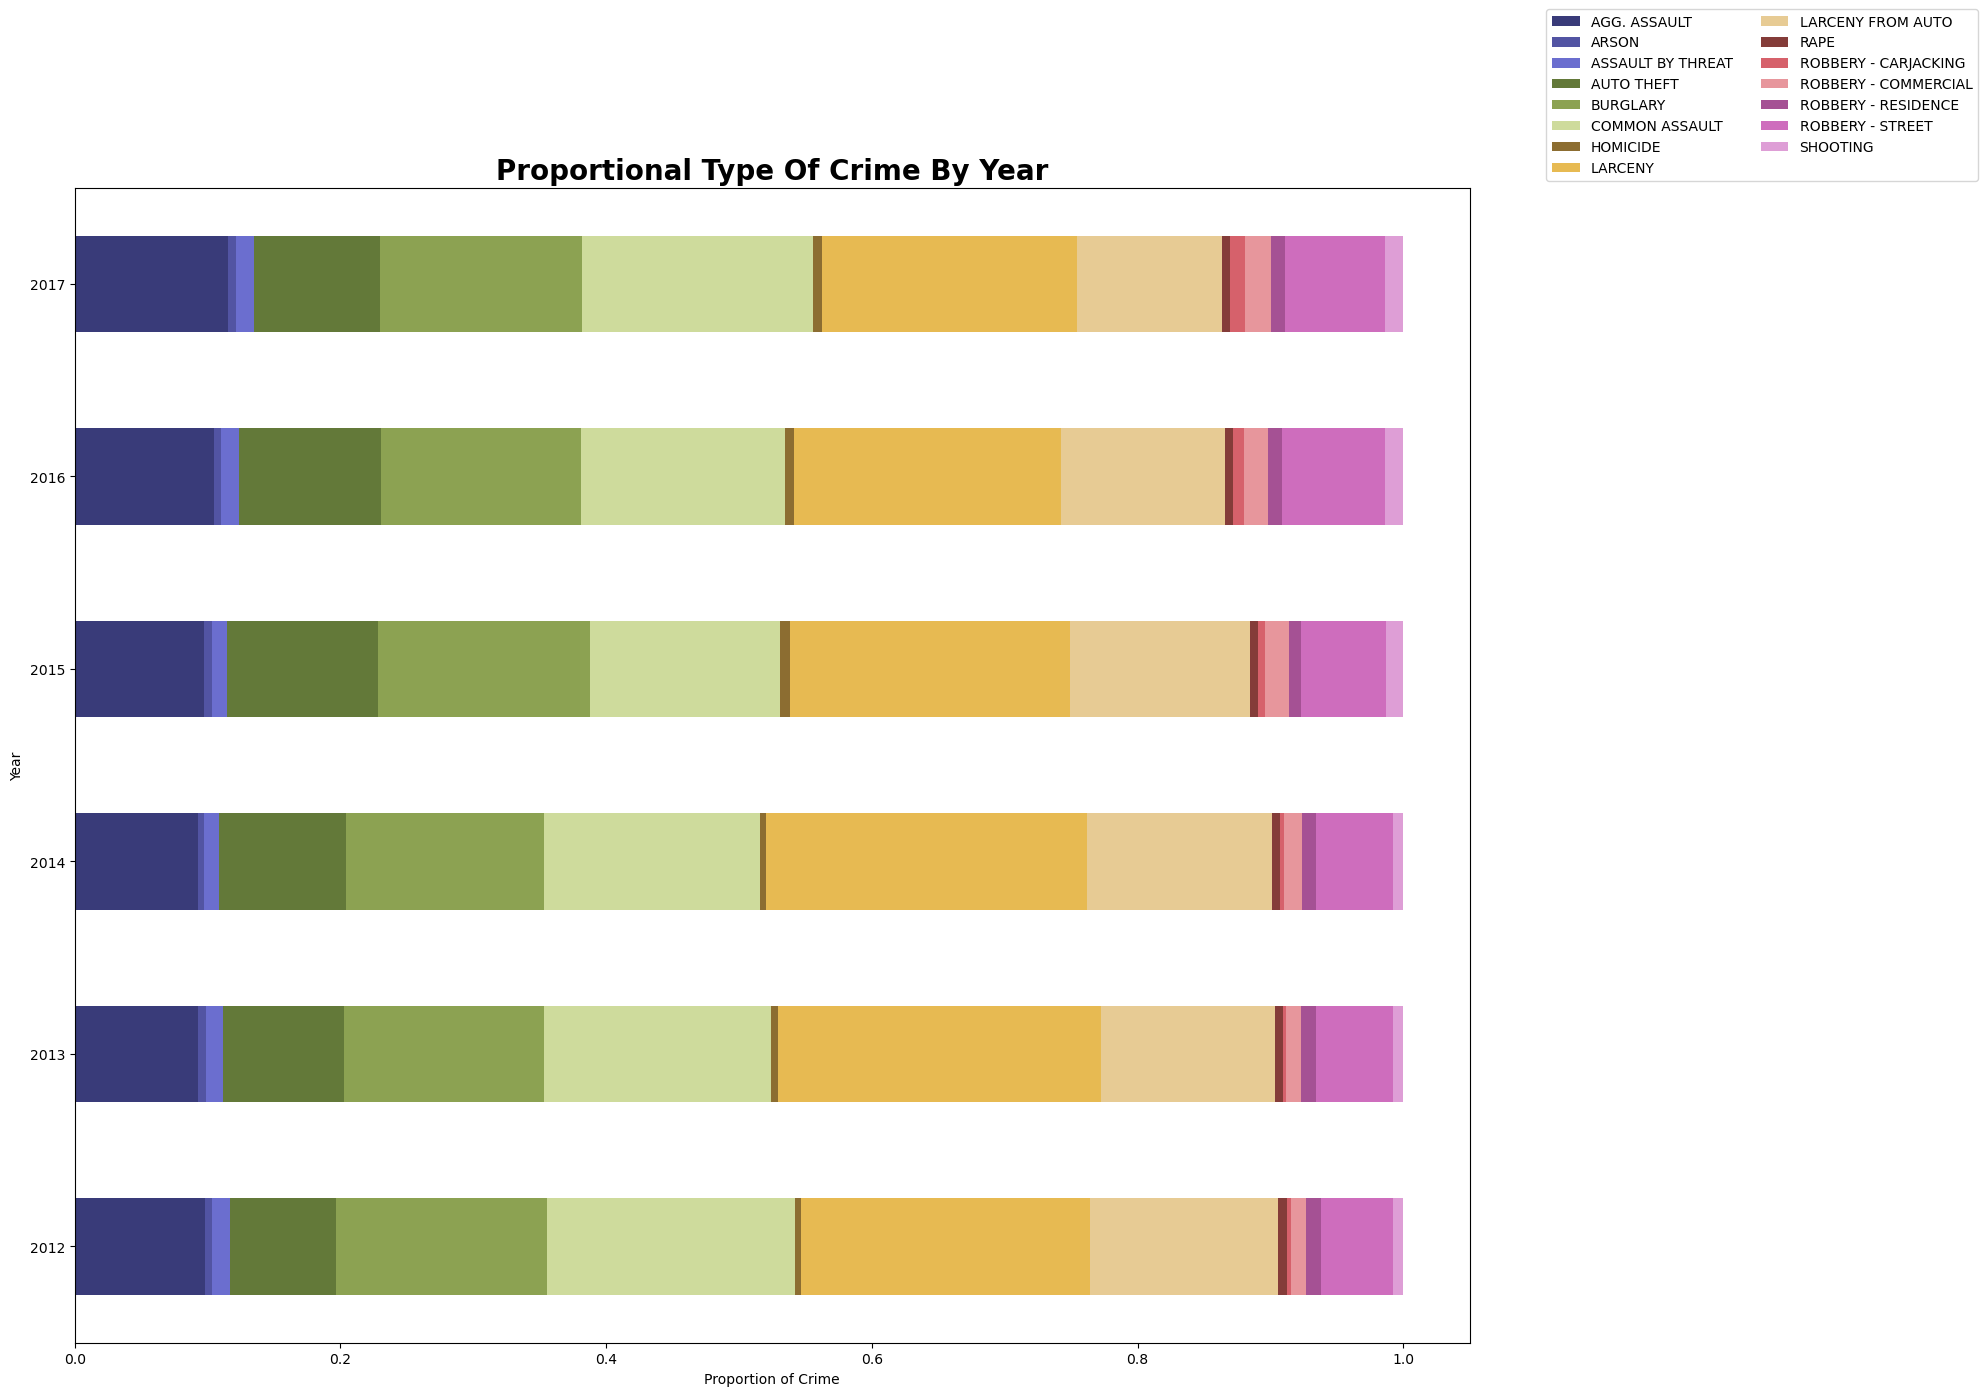

In [31]:
# get crime type data by year
df["Year"] = df["CrimeDate"].dt.year
year = df["Year"]
# create dataframe
crime_type_by_year_df = pd.DataFrame(
    {
        "Type of Crime": crime_type,
        "Year": year,
    }
)

# cross tabulation proportions for crime by year
cross_tab_prop_year = pd.crosstab(
    index=crime_type_by_year_df["Year"],
    columns=crime_type_by_year_df["Type of Crime"],
    normalize="index",
)
cross_tab_prop_year

# cross tabulation counts for crime by year
cross_tab_year = pd.crosstab(
    index=crime_type_by_year_df["Year"], columns=crime_type_by_year_df["Type of Crime"]
)

# create stacked horizontal chart of crime type by year
cross_tab_prop_year.plot(kind="barh", stacked=True, colormap="tab20b", figsize=(18, 15))

# formattine
plt.legend(bbox_to_anchor=(1.05, 1), loc="lower left", ncol=2)
plt.title("Proportional Type Of Crime By Year", fontsize=20, fontweight="bold")
plt.ylabel("Year")
plt.xlabel("Proportion of Crime")

plt.show()

August has the highest percentage of crimes. February the lowest.


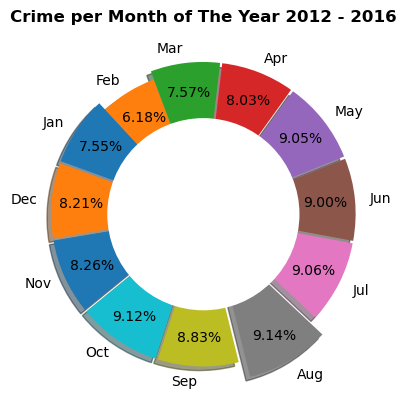

In [32]:
month_df = df.copy()
month_df = month_df[month_df.CrimeDate < "2017-01-01"]
month_df["Month"] = month_df.CrimeDate.dt.month
months = month_df.Month.value_counts().sort_index()

labels = [calendar.month_abbr[i] for i in months.index]


plt.pie(
    months.values,
    labels=labels,
    explode=(0.03, -0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.15, 0.03, 0.03, 0.03, 0.03),
    shadow=True,
    startangle=160,
    autopct="%1.2f%%",
    pctdistance=0.8,
    counterclock=False,
)

print("August has the highest percentage of crimes. February the lowest.")

plt.title("Crime per Month of The Year 2012 - 2016", fontweight="bold")

# gcf get current figure, gca get current axis
donut = plt.Circle((0, 0), 0.65, facecolor="white")
plt.gcf().gca().add_artist(donut)

plt.show()

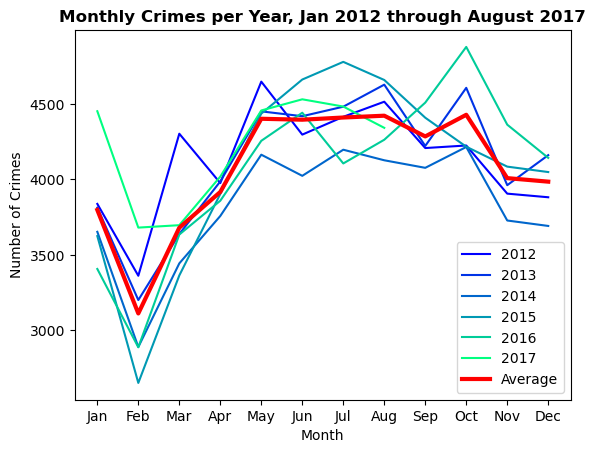

In [33]:

year_df = df.copy()
year_df["Year"] = year_df.CrimeDate.dt.year
year_df["Month"] = year_df.CrimeDate.dt.month
year_df = year_df[year_df.CrimeDate < "2017-09-01"]

_ = year_df.groupby("Month")["Year"].value_counts().unstack()
_.plot(kind="line", cmap=plt.colormaps.get_cmap("winter"))

avg = year_df.groupby("Month")["Year"].value_counts().unstack().mean(axis=1)
plt.plot(range(1, 13), avg, color="red", linewidth=3, label="Average")

# Format the plot
plt.xticks(range(1, 13), labels=calendar.month_abbr[1:])
plt.ylabel("Number of Crimes")
plt.title("Monthly Crimes per Year, Jan 2012 through August 2017", fontweight="bold")
plt.legend()

plt.savefig("Images/per_month.png")

plt.show()

## ANOVA

The number of victim-based crimes occuring is impacted by the month of the year, according to the extremely small pvalue.

In [34]:
month_df = df.copy()
month_df["Month"] = month_df.CrimeDate.dt.month
month_df["Year"] = month_df.CrimeDate.dt.year
# month_df = year_df.groupby("Month")["Year"].value_counts().unstack()
# month_df = month_df.reset_index()

jan = month_df[month_df.Month == 1].groupby(month_df.Year).size()
feb = month_df[month_df.Month == 2].groupby(month_df.Year).size()
mar = month_df[month_df.Month == 3].groupby(month_df.Year).size()
apr = month_df[month_df.Month == 4].groupby(month_df.Year).size()
may = month_df[month_df.Month == 5].groupby(month_df.Year).size()
jun = month_df[month_df.Month == 6].groupby(month_df.Year).size()
jul = month_df[month_df.Month == 7].groupby(month_df.Year).size()
aug = month_df[month_df.Month == 8].groupby(month_df.Year).size()
sep = month_df[month_df.Month == 9].groupby(month_df.Year).size()
oct = month_df[month_df.Month == 10].groupby(month_df.Year).size()
nov = month_df[month_df.Month == 11].groupby(month_df.Year).size()
dec = month_df[month_df.Month == 12].groupby(month_df.Year).size()

print(
    f"""{st.f_oneway(jan, feb, mar, apr, may, jun, jul, aug, sep, oct, nov, dec)}
Month has a statistical impact on the frequency of crime over a year, as evidenced by the extremely low pvalue."""
)

F_onewayResult(statistic=3.337649313618808, pvalue=0.0013481654466416175)
Month has a statistical impact on the frequency of crime over a year, as evidenced by the extremely low pvalue.
